# Osteoarthritis-Analyse mit Deep Learning
## Transfer-Learning
Nikolas Wilhelm

<table><tr>
<td> <img src="./img/fastai.png" alt="Drawing" style="width: 250px;"/> </td>
<td> <img src="./img/pytorch.png" alt="Drawing" style="width: 250px;"/> </td>
</tr></table>

fastai:
https://www.fast.ai/

Pytorch:
https://pytorch.org/

Knee Osteoarthritis Severity Grading Dataset:
http://dx.doi.org/10.17632/56rmx5bjcr.1

## Importiere die relevanten Packete

Um diese zu installieren ist der Befehl: `conda install -c pytorch -c fastai fastai`

In [17]:
from fastai.vision import * # The complete Fastai vision library
from fastai.metrics import error_rate # For Determining the accuracy

# 1. Erstelle den "DataBunch"
## "Databunch" enthält die Trainings- und Validierungsdaten:

Dazu müssen wir zunächst den Datensatz herunterladen und entpacken: (Hier 6.7GB)

http://dx.doi.org/10.17632/56rmx5bjcr.1

In [42]:
# ToDo: Edit your personal path here!
path = 'C:/Users/ga46yeg/data/KneeXrayData/ClsKLData/kneeKL224'
#path = 'C:/Users/Niko/Documents/data/KneeXrayData/ClsKLData/kneeKL224'

## Aus allen daten innerhalb des Ordners lässt sich eine Liste der Bilder erstellen:

In [43]:
data = ImageList.from_folder(path)
data

ImageList (8260 items)
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
Path: C:\Users\ga46yeg\data\KneeXrayData\ClsKLData\kneeKL224

## Wir wollen nach Trainings- und Validierungsdaten unterteilen:

<table><tr>
<td> <img src="./img/folder_structure.png" alt="Drawing" style="width: 600px;"/> </td>
</tr></table>



In [44]:
?? data.split_by_folder

Anwendung und Betrachtung:

In [45]:
data = data.split_by_folder(valid='val')
data

ItemLists;

Train: ImageList (5778 items)
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
Path: C:\Users\ga46yeg\data\KneeXrayData\ClsKLData\kneeKL224;

Valid: ImageList (826 items)
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
Path: C:\Users\ga46yeg\data\KneeXrayData\ClsKLData\kneeKL224;

Test: None

Um eine Klassifizierung Durchführen zu können brauchen wir "Labels"!

<table><tr>
<td> <img src="./img/data_labels.png" alt="Drawing" style="width: 600px;"/> </td>
</tr></table>


In [46]:
data = data.label_from_folder()
data

LabelLists;

Train: LabelList (5778 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
0,0,0,0,0
Path: C:\Users\ga46yeg\data\KneeXrayData\ClsKLData\kneeKL224;

Valid: LabelList (826 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
0,0,0,0,0
Path: C:\Users\ga46yeg\data\KneeXrayData\ClsKLData\kneeKL224;

Test: None

Daraus lässt sich bereits der benötigte "DataBunch" bereits erstellen!

In [47]:
batch_size = 16
data = data.databunch(bs=batch_size)

Zu letzt fehlt noch die Normalisierung der Eingangsdaten!
Für "Transfer Learning" sollten die gleiche Normalisierung wie für den vortrainierten Datensatz verwendet werden!

In [48]:
data = data.normalize(imagenet_stats)

Wichtig!! Schau den DataBunch an!

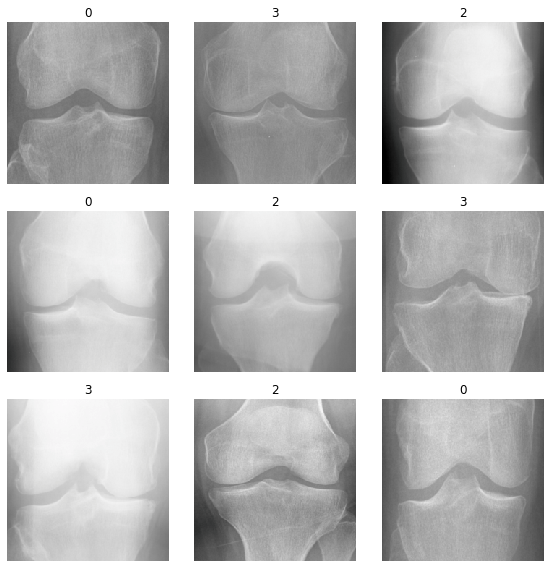

In [49]:
data.show_batch(rows=3, figsize=(8,8))

Fertig ist der DataBunch!

-- Nur Transformationen fehlen!

- Spiegele Horizontal (linkes/rechtes Knie)

<img src="./img/flip.jpg" width = 50>

- Rotiere um +/- 10 Grad

<img src="./img/rotate.png" width = 50>

- Skaliere um 0.9 bis 1.1

<img src="./img/scale.png" width = 50>

In [54]:
??get_transforms

### Fasse die Erstellung des DataBunch zusammen:
* Mit Transforms

In [66]:
tfms = get_transforms()
batch_size = 16

# the order matters!
data = (
    ImageList.from_folder(path)
    .split_by_folder(valid='val')
    .label_from_folder()
    .transform(tfms)
    .databunch(bs=batch_size)
    .normalize(imagenet_stats)
)

### Finales Überprüfen des "Databunch":

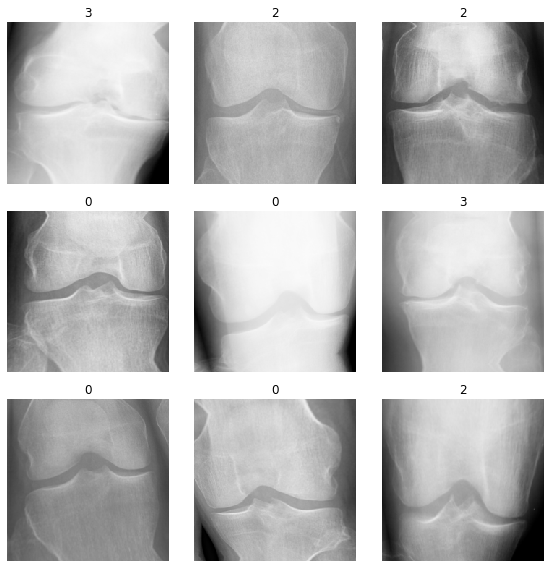

In [56]:
data.show_batch(rows=3, figsize=(8,8))

# 2. Wir brauchen das Lernende Netzwerk:

### Für Bilddaten: Convolutional Neural Network!

<img src="./img/conv_nn.jpeg">

In [67]:
learn = cnn_learner(data, models.resnet101, metrics=error_rate)

## Was enthält dieser "Learner" alles??

In [59]:
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

In [61]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

<img src="./img/resnet34.png">

# 3. Training!!

### -> Bei Transfer Learning wird NUR der letzte Layer trainiert!

In [62]:
?? learn.fit_one_cycle

epoch,train_loss,valid_loss,error_rate,time
0,2.101836,2.615930,0.566586,02:28
1,1.524094,1.651434,0.520581,02:17
2,1.266416,1.192646,0.507264,02:17
3,1.169738,1.075950,0.439467,02:18
4,1.086221,1.037494,0.437046,02:18
5,1.014502,0.936503,0.398305,02:19
6,0.978941,0.953559,0.410412,02:19
7,0.875893,0.918970,0.382567,02:17
8,0.862009,0.881460,0.363196,02:17
9,0.857307,0.879219,0.361985,02:17


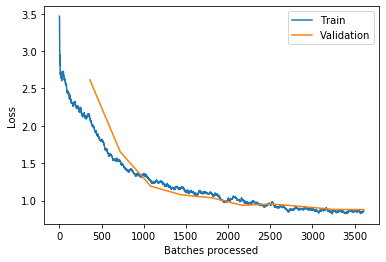

In [17]:
learn.fit_one_cycle(10) # train for 10 cycles
learn.save('./stage1') # save the result
learn.recorder.plot_losses()

In [18]:
learn = learn.load('./stage1')

In [19]:
interp = ClassificationInterpretation.from_learner(learn)
losses, idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

True

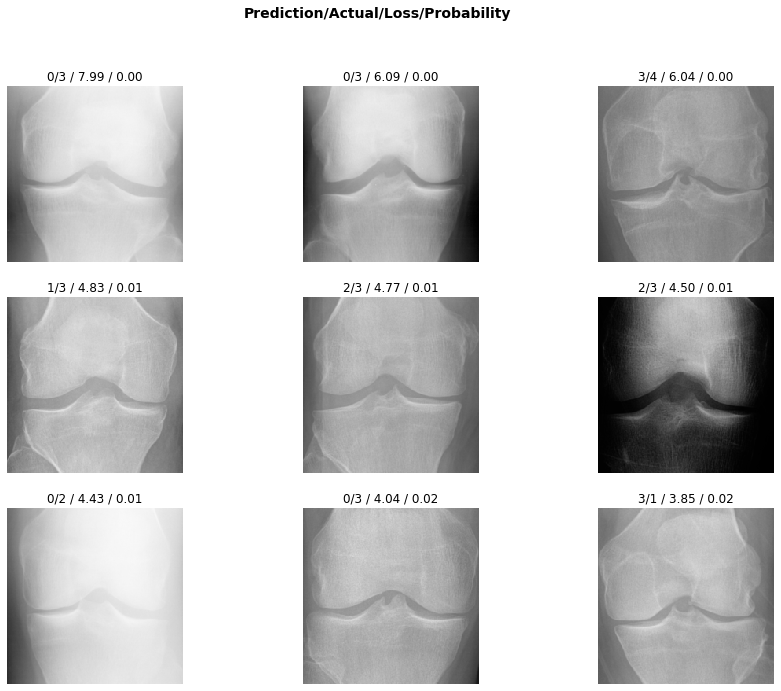

In [20]:
interp.plot_top_losses(9, figsize=(15,11))

In [21]:
doc(interp.plot_top_losses)

## Zeige die Confusion Matrix

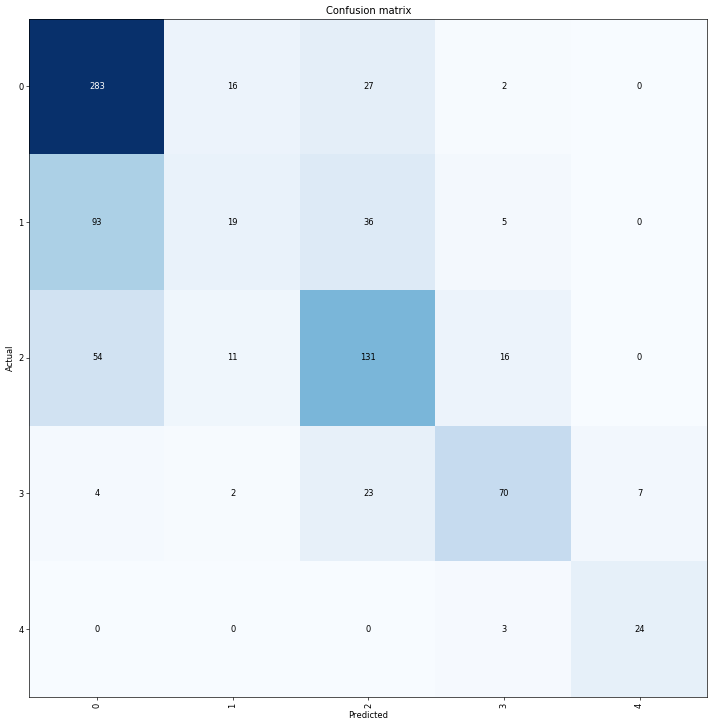

In [22]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

# 4. Wie geht es besser??

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


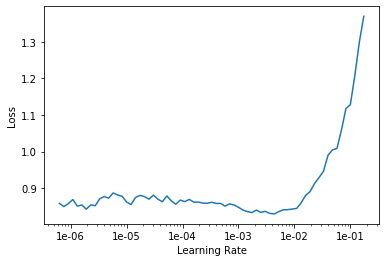

In [24]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,error_rate,time
0,0.886866,0.947454,0.386199,03:06
1,0.913940,0.958255,0.387409,03:06
2,0.908847,0.904536,0.381356,03:07
3,1.014423,0.965312,0.423729,03:07
4,1.021861,1.050443,0.492736,03:07
5,1.002153,0.923364,0.377724,03:07
6,1.001049,0.988816,0.418886,03:07
7,0.956123,0.905004,0.380145,03:07
8,0.945420,0.983638,0.371671,03:07
9,0.981171,0.866948,0.371671,03:07


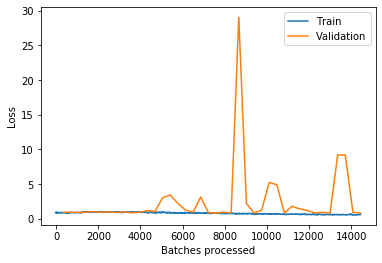

In [25]:
learn.unfreeze()
learn.fit_one_cycle(40, max_lr=slice(1e-5,1e-2))
learn.save('./stage_exp')
learn.recorder.plot_losses()

Vergleich mit Veröffentlichung:
<table><tr>
<td> <img src="./img/paper_result.png" alt="Drawing" style="width: 600px;"/> </td>
</tr></table>

In [89]:
learn.load('./stage2');

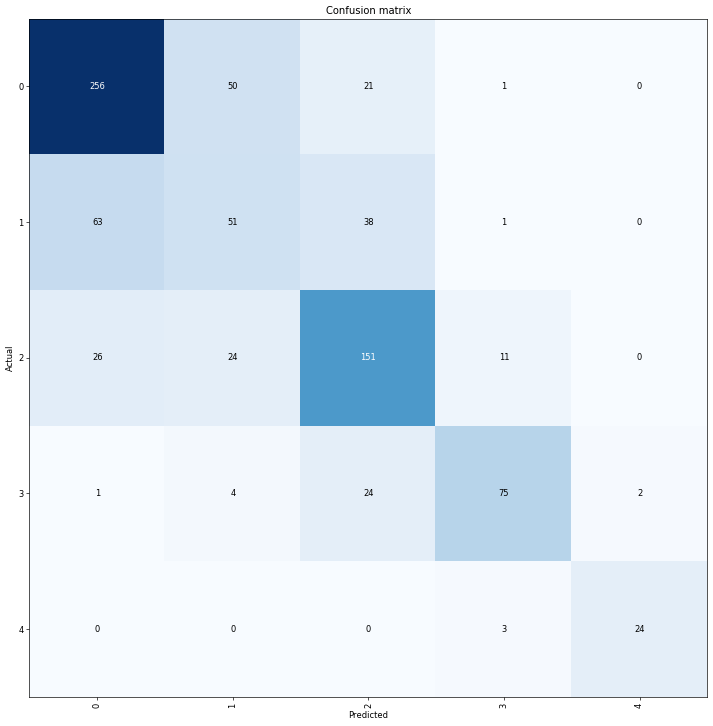

In [90]:
interp = ClassificationInterpretation.from_learner(learn)
losses, idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

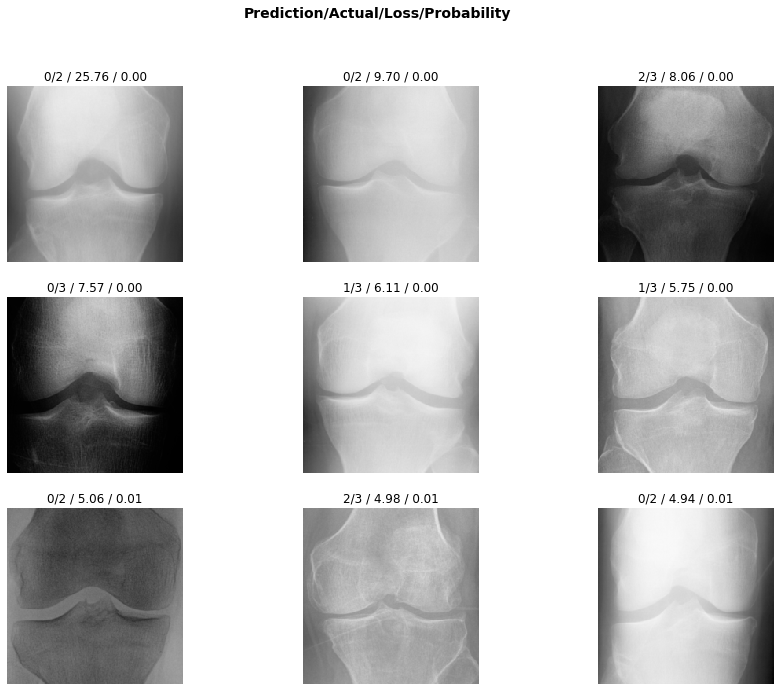

In [91]:
interp.plot_top_losses(9, figsize=(15, 11))

# 5. Aber das ist eben nur eine Black Box...

In [77]:
from fastai.callbacks.hooks import *

Category 0

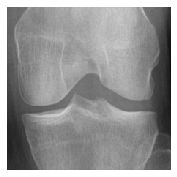

In [143]:
idx = 200
x, y = data.valid_ds[idx]
x.show()
data.valid_ds.y[idx]

In [144]:
m = learn.model.eval()

In [145]:
xb, _ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()
xb.shape
data.denorm(xb)[0].shape

torch.Size([3, 224, 224])

In [146]:
def hooked_backward(cat=y):
    with hook_output(m[0]) as hook_a:
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(xb)
            preds[0, int(cat)].backward()
    return hook_a, hook_g

In [147]:
hook_a,hook_g = hooked_backward()

In [148]:
acts = hook_a.stored[0].cpu()
acts.shape

torch.Size([2048, 7, 7])

In [149]:
avg_acts = acts.mean(0)
avg_acts.shape

torch.Size([7, 7])

In [150]:
def show_heatmap(hm):
    _,ax = plt.subplots()
    xb_im.show(ax)
    ax.imshow(hm, alpha=0.6, extent=(0,224,224,0),
              interpolation='bilinear', cmap='magma');

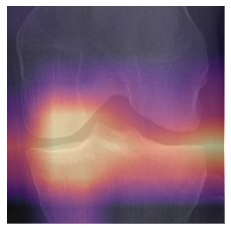

In [151]:
show_heatmap(avg_acts)

## Grad-CAM (optional)

In [152]:
grad = hook_g.stored[0][0].cpu()
grad_chan = grad.mean(1).mean(1)
grad.shape,grad_chan.shape
grad.shape

torch.Size([2048, 7, 7])

In [153]:
mult = (acts*grad_chan[...,None,None]).mean(0)

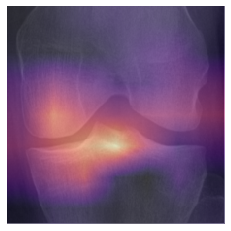

In [154]:
show_heatmap(mult)